In [1]:
import requests
import google.auth
import json
import time
from datetime import datetime, timedelta
from google.auth.transport.requests import Request as GoogleAuthRequest
from pprint import pprint
import pandas as pd
import matplotlib.pyplot as plt
import os.path

In [2]:
ENV='prod'

workflow_name = "BeagleImputationValidation"
snps_imputed_stats_wdl_variable_name = "imputed_r2_output_snps"
indels_imputed_stats_wdl_variable_name = "imputed_r2_output_indels"

workspace_project = "allofus-drc-imputation"
workspace_name = "AOU_ANVIL_imputation_reference_panel_validation"

submission_id_1 = '398eb1bc-d24e-427d-aa60-943c37f72323'
workflow_id_1 = '9f9b290a-1c4f-4ee4-a333-5a977507081a'
submission_id_2 = '4e66bfef-d169-4b29-97c1-fff03153e5e8'
workflow_id_2 = 'ea9b6663-3dc9-4430-947e-f3d116ab0518'

In [3]:
def get_access_token():
    """Get access token."""
    credentials, _ = google.auth.default()
    
    credentials.refresh(GoogleAuthRequest())
    
    return credentials.token


def get_workflows_url(workspace_project, workspace_name):
    return f"https://rawls.dsde-{ENV}.broadinstitute.org/api/workspaces/{workspace_project}/{workspace_name}"


def get_cromwell_workflow_outputs(workflows_url, submission_id, workflow_id, token, attempt=1):
    uri = f"{workflows_url}/submissions/{submission_id}/workflows/{workflow_id}/outputs"
    
    headers = {"Authorization": "Bearer " + token,
               "accept": "application/json"}
    
    response = requests.get(uri, headers=headers)
    status_code = response.status_code
    
    if status_code != 200:
        if status_code == 404 and attempt <= 2:
            attempt += 1
            # sometimes we get a transient 404, we should retry twice
            print(f"retrying call after {attempt} sec, attempt {attempt}")
            time.sleep(attempt)
            return get_cromwell_workflow_outputs(workflows_url, submission_id, workflow_id, token, attempt)
        print("error fetching cromwell workflow metadata")
        print(response.text)

    return response.json()

def get_imputed_outputs(workflows_url, submission_id, workflow_id, token):
    response = get_cromwell_workflow_outputs(workflows_url, submission_id, workflow_id, token)
    return response['tasks'][f'{workflow_name}']['outputs'][f'{workflow_name}.{snps_imputed_stats_wdl_variable_name}'], response['tasks'][f'{workflow_name}']['outputs'][f'{workflow_name}.{indels_imputed_stats_wdl_variable_name}']

In [4]:
print(f"running on {ENV}")
token = get_access_token()
workflows_url = get_workflows_url(workspace_project, workspace_name)

running on prod


In [5]:
snps_imputed_stats_gcs_path_1, indels_imputed_stats_gcs_path_1 = get_imputed_outputs(workflows_url, submission_id_1, workflow_id_1, get_access_token())
snps_imputed_stats_gcs_path_2, indels_imputed_stats_gcs_path_2 = get_imputed_outputs(workflows_url, submission_id_2, workflow_id_2, get_access_token())


In [6]:
!gcloud storage cp {snps_imputed_stats_gcs_path_1} snps_output_1.tsv
!gcloud storage cp {snps_imputed_stats_gcs_path_2} snps_output_2.tsv

!gcloud storage cp {indels_imputed_stats_gcs_path_1} indels_output_1.tsv
!gcloud storage cp {indels_imputed_stats_gcs_path_2} indels_output_2.tsv


Copying gs://fc-secure-070f3cd7-c0bc-4125-90e4-7962a696cc72/submissions/398eb1bc-d24e-427d-aa60-943c37f72323/BeagleImputationValidation/9f9b290a-1c4f-4ee4-a333-5a977507081a/call-RunBeagleImputedR2Snps/aou_anvil_merged.SNPs.imputed_stats.tsv to file://snps_output_1.tsv
  Completed files 1/1 | 893.0B/893.0B                                          


To take a quick anonymous survey, run:
  $ gcloud survey

Copying gs://fc-secure-070f3cd7-c0bc-4125-90e4-7962a696cc72/submissions/4e66bfef-d169-4b29-97c1-fff03153e5e8/BeagleImputationValidation/ea9b6663-3dc9-4430-947e-f3d116ab0518/call-RunBeagleImputedR2Snps/aou_only.SNPs.imputed_stats.tsv to file://snps_output_2.tsv
  Completed files 1/1 | 896.0B/896.0B                                          
Copying gs://fc-secure-070f3cd7-c0bc-4125-90e4-7962a696cc72/submissions/398eb1bc-d24e-427d-aa60-943c37f72323/BeagleImputationValidation/9f9b290a-1c4f-4ee4-a333-5a977507081a/call-RunBeagleImputedR2Indels/aou_anvil_merged.INDELS.imputed_stats.tsv to fi

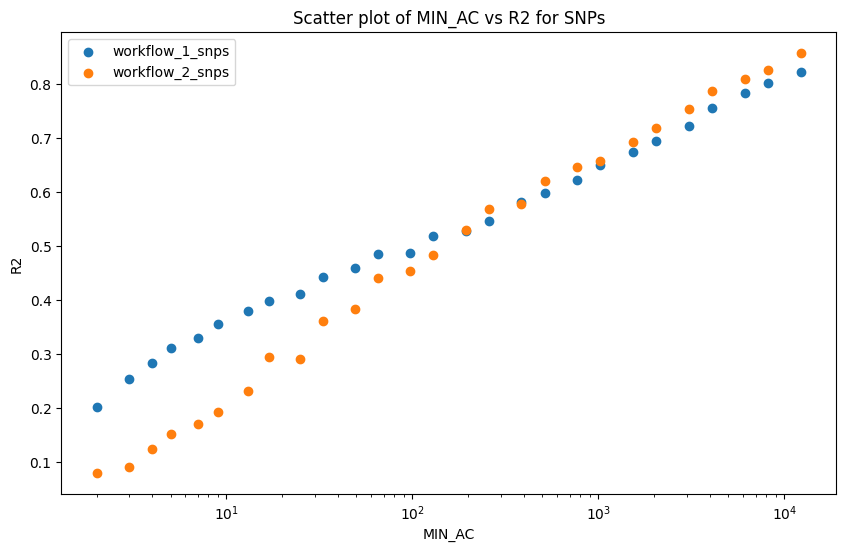

In [7]:
# Read the TSV file
df_1_snps = pd.read_csv("snps_output_1.tsv", sep="\t")
df_1_indels = pd.read_csv("indels_output_1.tsv", sep="\t")
df_2_snps = pd.read_csv("snps_output_2.tsv", sep="\t")
df_2_indels = pd.read_csv("indels_output_2.tsv", sep="\t")


## Change to true if you want to filter 0's from the data
filter_zeros = False
df_filtered_1_snps = df_1_snps[df_1_snps['R2'] > 0] if filter_zeros else df_1_snps
df_filtered_1_indels = df_1_indels[df_1_indels['R2'] > 0] if filter_zeros else df_1_indels
df_filtered_2_snps = df_2_snps[df_2_snps['R2'] > 0] if filter_zeros else df_2_snps
df_filtered_2_indels = df_2_indels[df_2_indels['R2'] > 0] if filter_zeros else df_2_indels


# Create the snps scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(df_filtered_1_snps['MIN_AC'], df_filtered_1_snps['R2'], label='workflow_1_snps')
plt.scatter(df_filtered_2_snps['MIN_AC'], df_filtered_2_snps['R2'], label='workflow_2_snps')

plt.xscale("log")
plt.legend()
plt.xlabel('MIN_AC')
plt.ylabel('R2')
plt.title('Scatter plot of MIN_AC vs R2 for SNPs')
plt.show()

<Figure size 640x480 with 0 Axes>

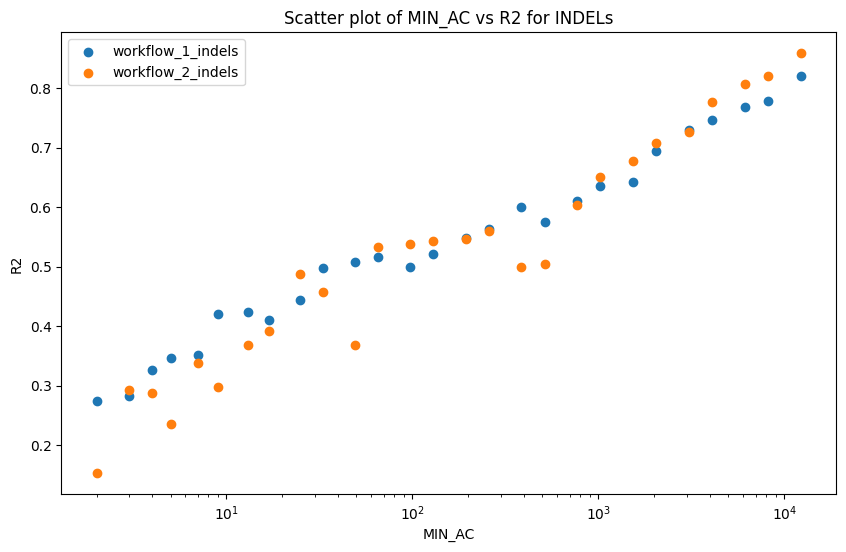

In [8]:
# Create the indels scatter plot
plt.clf()
plt.figure(figsize=(10, 6))
plt.scatter(df_filtered_1_indels['MIN_AC'], df_filtered_1_indels['R2'], label='workflow_1_indels')
plt.scatter(df_filtered_2_indels['MIN_AC'], df_filtered_2_indels['R2'], label='workflow_2_indels')

plt.xscale("log")
plt.legend()
plt.xlabel('MIN_AC')
plt.ylabel('R2')
plt.title('Scatter plot of MIN_AC vs R2 for INDELs')
plt.show()